# Exercise 4
In this exercise, we will control a 2D drone depicted in the figure below <br>
<img src='quadrotor.png' width="300">

Consider the following simplified linear model of the drone
$$\begin{align}
    x_{n+1} = A
    x_n + B u_n
\end{align}$$

where the components of the state $x_n$ correspond to the horizontal position and velocity of the quadrotor, its vertical position and velocity and its orientation and angular velocity. The control vector
$u_n$ contains the forces produced by the rotors (our control inputs).
The module ```quadrotor.py``` defines the matrices $A$ and $B$ and code to generate a simulation of the drone.

In [1]:
## what we need to do computation and display the drone
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import quadrotor

In [2]:
# we define a few constants
xdim = 6 # dimension of the state (p,v)
udim = 2 # dimension of the control (u)
N = 500 # number of steps
nvars = N*udim + (N+1)*xdim # total number of variables
dt = 0.01 #delta t
sdim = xdim + udim # dimension of total state vector
## We define the cost
Q = np.eye(xdim)
Q[0,0] = Q[2,2] = Q[4,4] = 10.  # position penalty
Q[1,1] = Q[3,3] = Q[5,5] = 5.   # velocity penalty
R = np.eye(udim) * 0.01
des_state = np.array([3,0,3,0,0,0,0,0]).reshape(-1,1)


## we create G
def get_cost_matrix_G(Q, R):
    '''
    we are making this a function so we can reuse this later in the next cells when we play with costs
    '''
    G = np.zeros((nvars, nvars))
    G[-xdim:, -xdim:] = Q
    mini_G = np.block([[Q, np.zeros((xdim, udim))], [np.zeros((udim, xdim)), R]])
    # Fill G blocks
    for i in np.arange(0, (xdim + udim)*N, (xdim+udim)):
        G[i:i+8, i:i+8] = mini_G
    return G

G = get_cost_matrix_G(Q,R)
print(G.shape)

(4006, 4006)


In [3]:
##### CREATE THE KKT SYSTEM #####
## create the linear equality constraint
M = np.zeros([xdim * (N+1), nvars])
d = np.zeros([xdim * (N+1)])
mini_M = np.block([[-np.eye(xdim), np.zeros((xdim, udim))], [quadrotor.A, quadrotor.B]])  # Define mini_M correctly
j = 0
for i in np.arange(0, 8*N, 8):
    M[j:(j+12), i:(i+8)] = mini_M  # Assign the mini_M block to M
    j += 6  # Increment by 6 for the next block
M[0:6, 0:6] = np.identity(6)
M[-6:, -6:] = -np.identity(6)

print(M.shape)

# Define p and ydes vectors
p = np.zeros((6 * (N + 1), 1))
ydes = np.block([[np.kron(np.ones((N, 1)), des_state)], [des_state[0:6]]])

# Compute G_des
G_des = np.matmul(G, ydes)

# Create the KKT matrix
nconstraints = M.shape[0]
nvars = G.shape[1]  # Assuming G has `nvars` columns
KKT = np.zeros((nvars + nconstraints, nvars + nconstraints))

# Fill the KKT matrix with appropriate blocks
KKT[0:nvars, 0:nvars] = G
KKT[nvars:, 0:nvars] = M
KKT[0:nvars, nvars:] = M.T

# Define the right-hand side vector (f)
f = np.zeros((nvars + nconstraints, 1))
f[0:nvars] = G_des  # Top part of f (matching `G_des`)
f[nvars:, 0] = p.flatten()  # Bottom part of f (matching `p`)

# Solve the KKT system
yl = np.linalg.solve(KKT, f)

(3006, 4006)


In [4]:
x_pos = yl[0:N*8+6:8].flatten()
x_vel = yl[1:N*8+6:8].flatten()
y_pos = yl[2:N*8+6:8].flatten()
y_vel = yl[3:N*8+6:8].flatten()
angle = yl[4:N*8+6:8].flatten()
angle_vel = yl[5:N*8+6:8].flatten()
control1 = yl[6:N*8+6:8].flatten()
control2 = yl[7:N*8+6:8].flatten()

x0 = np.array([
    x_pos,      # Shape: (501,)
    x_vel,      # Shape: (501,)
    y_pos,      # Shape: (501,)
    y_vel,      # Shape: (501,)
    angle,      # Shape: (501,)
    angle_vel   # Shape: (501,)
])

# print(f"x0 shape: {x0.shape}")  # Should output: (6, 501)

u = np.vstack([
    control1.flatten(),
    control2.flatten()
])  # Shape: (2, 500)

u = np.hstack([u, np.zeros((2, 1))])  # Shape: (2, 501)

# plt.figure(figsize=[9,9])
# plt.subplot(3,2,1)
# plt.ylabel('Horizontal Position')
# plt.plot(x_pos, 'x')
# plt.subplot(3,2,2)
# plt.ylabel('Horizontal Velocity')
# plt.plot(x_vel, 'x')
# plt.subplot(3,2,3)
# plt.ylabel('Vertical Position')
# plt.plot(y_pos, 'x')
# plt.subplot(3,2,4)
# plt.ylabel('Vertical Velocity')
# plt.plot(y_vel, 'x')
# plt.subplot(3,2,5)
# plt.ylabel('Orientation')
# plt.plot(angle, 'x')
# plt.subplot(3,2,6)
# plt.ylabel('Angular Velocity')
# plt.plot(angle_vel, 'x')

# plt.figure(figsize=[9,6])
# plt.subplot(2,1,1)
# plt.plot(control1, 'x')
# plt.ylabel('Control 1: Rotor Force 1')
# plt.subplot(2,1,2)
# plt.plot(control2, 'x')
# plt.ylabel('Control 2: Rotor Force 2')

# Optionally, animate the robot's movement (this requires the quadrotor animation function)
quadrotor.animate_robot(x0, np.array([control1, control2]), goal=[3, 3])  

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMBFtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EPtliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCNT/0/deNpxANBL7R6l87LmplBSGUsMQgNinSvYBoi8EPlGhxil7rIakrntmRfU0qiM0BAfkrs+
j5GFt2itzqQrfd3lpmJFXa+MNDKxweBUJBLIU/3nnkAFuR+wSGS1R3baEJNmkJtv9QkKzPL1D8ge
RrUHH6iEMmPeZXqEU9N+wdZ3pbWsr3CmKqMPW6QAPuubbXHn7oeRPpcbdx2PEb3Pjv0LQIvWJTS6
Yshbxb/waOsmEtAuFYiPugmHD0Uc6dBSOZpxtrApYbKI8CPKIfy/TrX2bfrUpEhHQzbwirKEIlUT
NdITskVOP3ljXm345J8cPx/JrUJ1COOAsTYQkvg0Md8oYnS+vnP9lhYagjUv1VaxVIXy4l9q/R/5
lafLwxIIzF0i9izWs8BCmmZ+Q2HTLrhE5wEE9Ieu7h0yGmIARMk4L6lXc+A0XRfZy93QeM8TOoX0
p7ppihRfjW6QgF98EdsMf+XSRj/KjMIABkq5pn7XQbd2Dr6GZeH2dBGreUNAo2X7FATl8SajrJNf
68mAv3m7XsVT5VnxHN24MuRJltQU9olC7UCJbZtWLMgXmMwbstRfe3zLEkOkbDULlCrrcOdh2MvL
F41k3GynFwfYihQ0XDoRqtABBdPtgScIp9eblfVdUzuzbxQD2pjqWdCSBMYGjktlg+iDuRlw+4FG
mOKucI8zOj5K0/GI/+P5J6H4+WfRlELuEri6Kyh7PjCVn/QrH6Q2srk+jVcOwDSrQ6B+6Vw5X/Tl
yJCr2TuVC96wArMzXtGXgTwbAiotDbdeq6pJIeS9CQ4Ar7cyEP9iFyoyd6gbYkDzQ5+o7zp3kfhZ
soWQkhO1Gtu/Tqw1ud+BPSUgs+frpvTqKgVjSHX9CtcwQ+X3O/6B+wQPMuLOGV2f4el0c8UanJG0
l7GiGoRAYS4LQwlLFNXz19OXhvjzuyJGbUXlQIIKPZhXynQ792iSVOPycHeALUpBGZzOFwn76dsm
ndG1jERiSi6RUQkakxkAlU6KtfJE3o90aN/tjUhpQTRPbvxfO/viUstjk/JnBaLPkEfGZEbX81C/
BhJ/EK9vTA25Ic8bzWBKXqktjMjfIA0BwQAAJlUmeqJLRzINuPD3CV2SMNRikWyCGL0R+RoZPws7
E/oDdfJ8v82ncOJU/EYRWle4q0Qh7Fiqux+iBwjzve6lq/tzbGXrwa4L6qvUysbCwb4PnAJjvvZV
L5HvAxwvjgdZtSd5imcZBMQJc/ZNIzLyCdP7f8QhyRSLdghz7ECqgnkXdbxE5u1GT5BmUa7B6ozm
3xWoa1cOI7AtfHqq43kdunlBJZcnujetAPvt3h1qW2RCUU64ZwmAGdhjwFE7xowySrlUGqfF2sE0
9OVQvqZHN1vlJ5rlQhQpO5oK4SpSHQ7rW9NPo/q99uX3nortsTsuDYZO+C3aLca9RxtogJNMevBd
i+GeSR/gD1+O13CxYCInm8LGR95nHRv+0xl4wcbdrDes0QAXMzLkljNrgibMwCevsm7/YDK9ev1I
QLPxTcW7FXMxv6js+6PEtkPc3qcpazb5eKwhhAqoxcEQYAABuMv7iDQce7nZlYAADiR8Viioy5YW
qaqjXMqjkymzEPJ4UY+jQ/eJplh+/egatLbKqrwAwdjUG4Ys4fvanX669/XxQGjWRf0JtXPO+lUO
e4Oy4ra6oQc5mBDj69c4KXZGxZbJSk/qzpr3FINZ5o1kB+X6/MuoMcKMpTKe1RuaiLEtP6V7EKQq
vcRfyy9x26oCbLRymKMWYWTJUT7qOkkwjY4bC892ao3Z6gXUO/PUOLvDYVhEbQCk0u+A9it8wdvz
gqB+CbsX4ofr4MKxvET6EZWffZUsSTZ//hYLMmz3dSEV07mpJE2YqFdYGG5pm2Il9A1RfUjQoayQ
JfoBHD7REjq//HblFvgU/syMXxW61nVceTP7f0qPsQFDrlT1CAAAAwALbXhjtLCmXtHz4K3d1VCS
KcmyoYhdWPUNCaannrV05j8CtyRvhPttuV1bOwEag4YycC7beqcqMaOgp1xVWkKRrzGbYbHrygxH
/7Ctw7jT/TAHn2Kb50M3yGg5z7BvgpH9/1w5U12VJqIKxZj6/kQB2KWWSVz+H1K32msTI4kpkJaL
7vAWBish98Ec/z1JX/Gtq8xxPXqdvdHDUOik1WSRm/iNOqTc+lPOR3g9Cr47AtmneU5vPOng8vD7
2Uq48nuFqPYgbzTe2Endl4isSIiRj5PAZL/9r//b2lInRC9tikh1WlS1xz5y7unp54vJqOhWtjCO
3FfEI4HvD+IU5dhQ+Y7eT4jZHKtNnxeumJ8MzOTWv6pzvRnOtOhwf9UVV27vC9K1vMMDQ+1L/TG5
CpqXWxX7vBzsrwiPjBP8cBNPPr6rd+oHoFJuM05WHkf3H/2gjn159oDsAFq2j+wnleuPE25H/goo
miUuN0VtxwwDAQCoVAtW9N+kZxggjCnm8dc202J26Fll+Yv1mEr5CNzdybnoThByJk9rNGBQh+rT
GJoFMlTrDHyKWz86CA1I048U0Qlu4LP55WcBVLfFPedq8db13iooyYKFMOn3kwTqtI+lXMzKBHRi
S95DroCdgMt3LJHwYemhqPM0MN9uRot52BW++xS3xj/GjsW3KuVcHiRoZKllU/YOiMQdr12rc6aJ
9z3JzUzyxl+h6tyaqD774jBZWxvY0/ozy4Zrbgg/cqCrXqMaOtNWqt/jfUL8RYA6ghtQFk1oiAp0
k82iZEBzwx3kFXW7xCxLoiCOUMGn5GPphSpyvwifxXNNXf7Mua7Gi9UnaZAAABp3td9P+43LeG9i
EU12wcflpj2xRUQ+35goY

(4006, 4006)
(4006, 1)
(4006, 4006)
(4006, 1)
(3006, 4006)
(3006, 1)


Final State = [ 2.98892e+00  3.60000e-04  2.99257e+00  2.40000e-04  2.30000e-03
 -9.00000e-05]
U1 : Max = 5.961974, Min = -22.69228
U2 : Max = 95.1026506, Min = -5.96197


Text(0, 0.5, 'Control 2: Rotor Force 2')

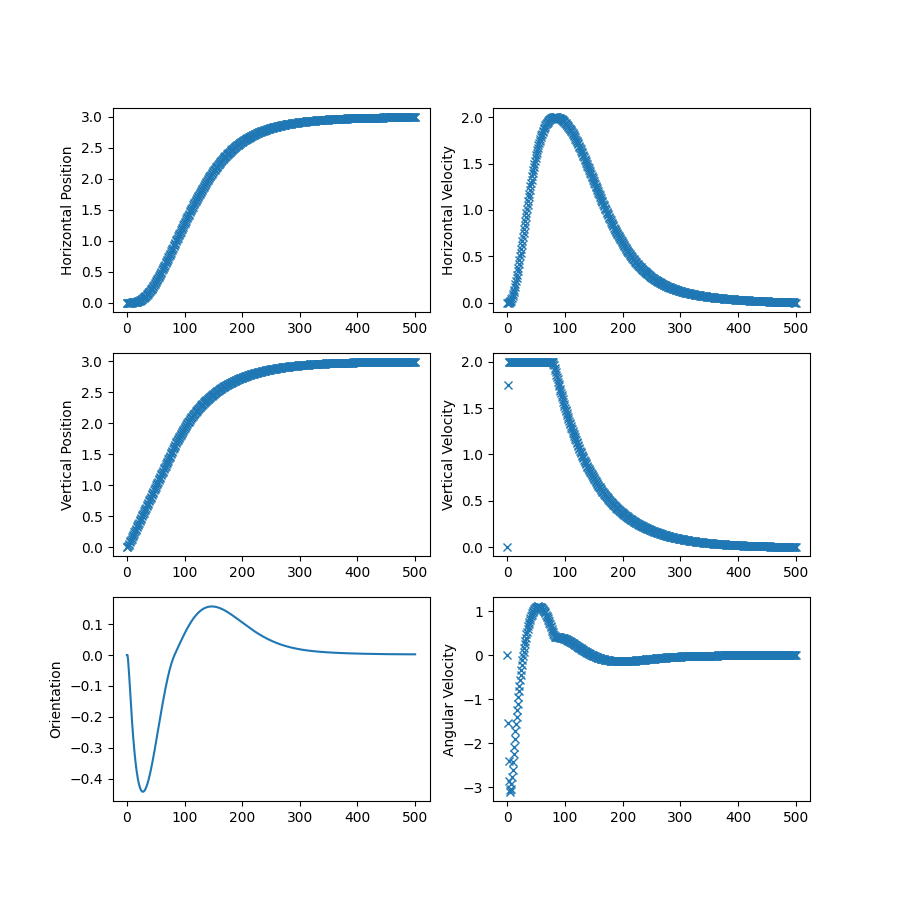

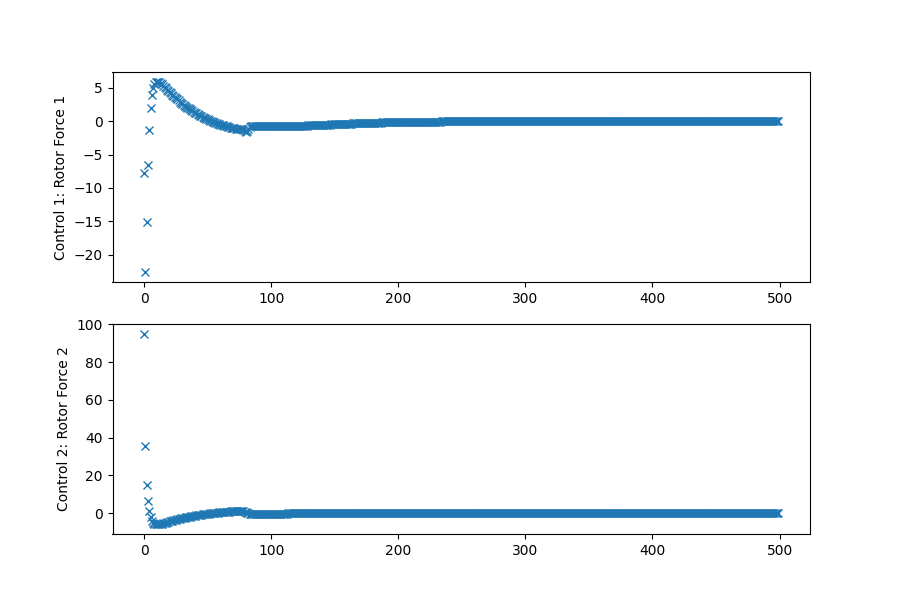

In [5]:
from qpsolvers import solve_qp


# x_desired = np.array([3, 0, 3, 0, 0, 0])
#######################
# # Construct the vector g^T, which contains the linear term in the objective function
# g = np.tile(np.hstack((((-x_desired) @ Q), [0]*udim)), N)
# g = g.reshape(g.shape[0], 1)  # Reshape to a column vector
# g = g.astype(np.float64)

# # Construct the vector p, which contains the initial state and zeros for the constraints
# p = np.zeros(((xdim*N), 1))
# p = p.astype(np.float64)


#######################


# Create an identity matrix H of size ((x_dim + u_dim) * N) to represent the inequality constraint matrix
# H is used to constrain both the states (x) and control inputs (u) for the optimization problem
H = np.zeros((nvars,nvars))
mini_H = np.zeros((8,8))
mini_H[1,1] = mini_H[3,3] = 1


H[-6:,-6:] = mini_H[0:6,0:6]
# Fill H blocks
for i in np.arange(0, (xdim + udim)*N, (xdim+udim)):
	H[i:i+8, i:i+8] = mini_H
# print(H[8:16,8:16])
# Define maximum values for each state variable (x) and control input (u)
x_max = np.array([3, 2, 3, 2, 0.5, 2.3])  # Maximum allowable values for state variables
u_max = np.array([5, 5])  # Maximum allowable values for control inputs
max_lims = np.array([0, 2, 0, 2, 0, 0, 0, 0]).reshape(-1,1)
# Construct the h vector to define the bounds for each time step
# Concatenate the x_max and u_max arrays and repeat them N times to form the full constraint vector


#####################################################################################################
# h = np.array([np.concatenate((x_max, u_max))] * N).flatten().reshape((-1, 1))
#####################################################################################################

h = np.zeros((nvars,1))
h[-6:] = max_lims[0:6]
for i in np.arange(0, 8*N, 8):
	h[i:i+8] = max_lims

# Solve the quadratic programming problem using the qpsolvers library with the cvxopt solver
# G, g: define the cost function
# H, h: define the inequality constraints
# M, p: define the equality constraints
print(G.shape)
print(G_des.shape)
print(H.shape)
print(h.shape)
print(M.shape)
# p = np.vstack((p, np.zeros((6,1)).reshape(-1,1)))
print(p.shape)
res = solve_qp(G, -G_des, H, h, M, p, solver='cvxopt')

# Extract the state values (x) from the solution vector, reshape them, and transpose to shape (6, 500)
x2 = res[:4000].reshape(-1, 8)[:, :6].T

# Extract the control values (u) from the solution vector, reshape them, and transpose to shape (2, 500)
u2 = res[:4000].reshape(-1, 8)[:, 6:].T

# Print the final state of the system (last time step) with rounded values for clarity
print(f"\n\nFinal State = {np.round(x2[:, N-1], 5)}")

# Print the maximum and minimum values of the first control input (u1)
print(f"U1 : Max = {round(u2[0].max(), 6)}, Min = {round(u2[0].min(), 5)}")

# Print the maximum and minimum values of the second control input (u2)
print(f"U2 : Max = {round(u2[1].max(), 7)}, Min = {round(u2[1].min(), 5)}")

x_pos = res[0:N*8+6:8].flatten()
x_vel = res[1:N*8+6:8].flatten()
y_pos = res[2:N*8+6:8].flatten()
y_vel = res[3:N*8+6:8].flatten()
angle = res[4:N*8+6:8].flatten()
angle_vel = res[5:N*8+6:8].flatten()
control1 = res[6:N*8+6:8].flatten()
control2 = res[7:N*8+6:8].flatten()

plt.figure(figsize=[9,9])
plt.subplot(3,2,1)
plt.ylabel('Horizontal Position')
plt.plot(x_pos, 'x')
plt.subplot(3,2,2)
plt.ylabel('Horizontal Velocity')
plt.plot(x_vel, 'x')
plt.subplot(3,2,3)
plt.ylabel('Vertical Position')
plt.plot(y_pos, 'x')
plt.subplot(3,2,4)
plt.ylabel('Vertical Velocity')
plt.plot(y_vel, 'x')
plt.subplot(3,2,5)
plt.ylabel('Orientation')
plt.plot(angle)
plt.subplot(3,2,6)
plt.ylabel('Angular Velocity')
plt.plot(angle_vel, 'x')

plt.figure(figsize=[9,6])
plt.subplot(2,1,1)
plt.plot(control1, 'x')
plt.ylabel('Control 1: Rotor Force 1')
plt.subplot(2,1,2)
plt.plot(control2, 'x')
plt.ylabel('Control 2: Rotor Force 2')

# Animate the quadrotor using the computed state (x2) and control inputs (u2) with the desired goal position
# quadrotor.animate_robot(x2, u2, goal=[3, 3])

In [6]:
# Print the final state of the system (last time step) with rounded values for clarity
print(f"\n\nFinal State = {np.round(x2[:, N-1], 5)}")

# Print the maximum and minimum values of the first control input (u1)
print(f"U1 : Max = {round(u2[0].max(), 6)}, Min = {round(u2[0].min(), 5)}")

# Print the maximum and minimum values of the second control input (u2)
print(f"U2 : Max = {round(u2[1].max(), 7)}, Min = {round(u2[1].min(), 5)}")



Final State = [ 2.98892e+00  3.60000e-04  2.99257e+00  2.40000e-04  2.30000e-03
 -9.00000e-05]
U1 : Max = 5.961974, Min = -22.69228
U2 : Max = 95.1026506, Min = -5.96197
